## Questions

1.	What factors play into police stops.
    a.	Given pieces of data about a particular stop, to what extent can we predict the race of the subject. 
    i.	AM vs PM 
2.	Can we predict what precincts that are more likely to pull over a particular gender/race. 
    a.	AM vs PM
3.	What is the correlation of prerace actually being accurate to actual race. 
4.	Are there times of higher citations. Morning, Afternoon, Evening, Night. 
5. Does the type of traffic stop impact whether a person is searched? H1 If suspicious vehicle stops are related to a person being searched, then the percentage of searches will be higher than the regular traffic stops for the year; H0 If suspicious vehicle stops are not related to a person being serarched, then the percentage of searches will be approximately equal for the year.



In [1]:
# importing dependencies
import numpy as np 
import pandas as pd
import dexplot as dxp
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
from pylab import *
import requests
import time
import json
import datetime
from pprint import pprint

# Google developer API key
#from config import google_key

# Census developer API key
#from config import census_key

## Data Load, Prep and Review

In [2]:
# reading csv file
StopOriginal = pd.read_csv('MplsStops_base.csv', parse_dates=['date'], infer_datetime_format=True)

StopOriginal['Time'] = StopOriginal.date.dt.time

# def get_sec(time_str):
#     h, m, s = time_str.split(':')
#     return int(h) * 3600 + int(m) * 60 + int(s)

# for time in StopOriginal:
#     convertedTime = get_sec(time['Time'])
#     StopOriginal.append({'convertedTime': convertedTime})

# displaying file header and five rows
StopOriginal.head()

,Unnamed: 0,idNum,date,problem,MDC,citationIssued,personSearch,vehicleSearch,preRace,race,gender,lat,long,policePrecinct,neighborhood,Time
0,6823,17-000003,2017-01-01 00:00:00,suspicious,MDC,NaN,NO,NO,Unknown,Unknown,Unknown,44.966617,-93.246458,1,Cedar Riverside,00:00:00
1,6824,17-000007,2017-01-01 00:03:00,suspicious,MDC,NaN,NO,NO,Unknown,Unknown,Male,44.980450,-93.271340,1,Downtown West,00:03:00
2,6825,17-000073,2017-01-01 00:23:00,traffic,MDC,NaN,NO,NO,Unknown,White,Female,44.948350,-93.275380,5,Whittier,00:23:00
3,6826,17-000092,2017-01-01 00:33:00,suspicious,MDC,NaN,NO,NO,Unknown,East African,Male,44.948360,-93.281350,5,Whittier,00:33:00
4,6827,17-000098,2017-01-01 00:37:00,traffic,MDC,NaN,NO,NO,Unknown,White,Female,44.979078,-93.262076,1,Downtown West,00:37:00


In [3]:
StopOriginal.dtypes

Unnamed: 0                 int64
idNum                     object
date              datetime64[ns]
problem                   object
MDC                       object
citationIssued            object
personSearch              object
vehicleSearch             object
preRace                   object
race                      object
gender                    object
lat                      float64
long                     float64
policePrecinct             int64
neighborhood              object
Time                      object
dtype: object

### Total Stops per Precinct

In [4]:
#stops per precinct 
StopOriginal['policePrecinct'].value_counts()

5    12825
4    12273
3     9792
2     9478
1     7552
Name: policePrecinct, dtype: int64

In [5]:
# storing csv into a pandas dataframe
initDF = pd.DataFrame(StopOriginal)
initDF.head()

,Unnamed: 0,idNum,date,problem,MDC,citationIssued,personSearch,vehicleSearch,preRace,race,gender,lat,long,policePrecinct,neighborhood,Time
0,6823,17-000003,2017-01-01 00:00:00,suspicious,MDC,NaN,NO,NO,Unknown,Unknown,Unknown,44.966617,-93.246458,1,Cedar Riverside,00:00:00
1,6824,17-000007,2017-01-01 00:03:00,suspicious,MDC,NaN,NO,NO,Unknown,Unknown,Male,44.980450,-93.271340,1,Downtown West,00:03:00
2,6825,17-000073,2017-01-01 00:23:00,traffic,MDC,NaN,NO,NO,Unknown,White,Female,44.948350,-93.275380,5,Whittier,00:23:00
3,6826,17-000092,2017-01-01 00:33:00,suspicious,MDC,NaN,NO,NO,Unknown,East African,Male,44.948360,-93.281350,5,Whittier,00:33:00
4,6827,17-000098,2017-01-01 00:37:00,traffic,MDC,NaN,NO,NO,Unknown,White,Female,44.979078,-93.262076,1,Downtown West,00:37:00


### Count of Stops (Removed 'other' values from MCD column)

In [6]:
#stops per police precinct after removing 'other' values from MDC column
cleanDF = initDF.drop(initDF[initDF.MDC == 'other'].index)
cleanDF['policePrecinct'].value_counts()

5    11435
4    10726
3     8345
2     7944
1     5249
Name: policePrecinct, dtype: int64

In [7]:
#data just for precinct 1 
precinct_one = cleanDF.loc[cleanDF['policePrecinct'] == 1 ]
precinct_two = cleanDF.loc[cleanDF['policePrecinct'] == 2 ]
precinct_three = cleanDF.loc[cleanDF['policePrecinct'] == 3 ]
precinct_four = cleanDF.loc[cleanDF['policePrecinct'] == 4 ]
precinct_five = cleanDF.loc[cleanDF['policePrecinct'] == 5 ]

In [8]:
one = precinct_one['problem'].value_counts()
one

suspicious    3326
traffic       1923
Name: problem, dtype: int64

### Total Stops

In [9]:
# calculating total stops 
precinct_df = pd.DataFrame(cleanDF['policePrecinct'].value_counts())
stops = precinct_df['policePrecinct'].sum()
stops

43699

### Count/Percent of Stops by Race

,race,%
Black,15220,34.83%
White,11703,26.78%
Unknown,9219,21.10%
East African,2188,5.01%
Latino,1858,4.25%
Native American,1516,3.47%
Other,1348,3.08%
Asian,647,1.48%


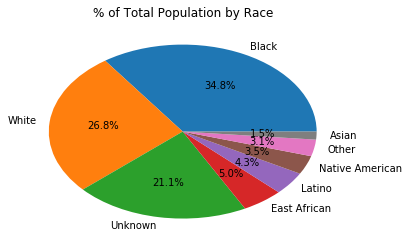

In [10]:
# Count of Stops by Race
race_count = pd.DataFrame(cleanDF['race'].value_counts())
race_count['%'] = race_count['race'] / stops * 100
race_count['%'] = race_count['%'].map("{:.2f}%".format)
display(race_count)
labels = ['Black','White', 'Unknown', 'East African', 'Latino', 'Native American', 'Other', 'Asian']

### This code makes donut pie charts
# fig1, ax1 = plt.subplots()
# ax1.pie(race_count['race'], labels=labels, autopct='%1.1f%%', startangle=90)
# #draw circle
# centre_circle = plt.Circle((0,0),0.70,fc='white')
# fig = plt.gcf()
# fig.gca().add_artist(centre_circle)
# # Equal aspect ratio ensures that pie is drawn as a circle
# ax1.axis('equal')  
# plt.tight_layout()
# #plt.show()


plt.pie(race_count['race'], labels=labels, autopct="%1.1f%%")
# adding title
plt.title("% of Total Population by Race")
# save the figure
plt.savefig("percent_pop_race.png")
# show the figure
plt.show()

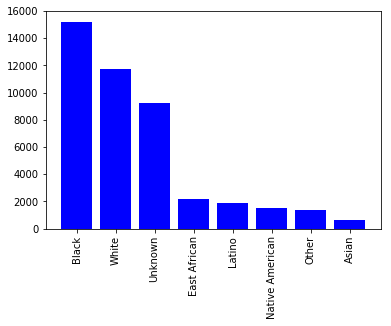

In [11]:
# the labels need to be fixed and despite about 5 attempts, I cannot find the magical code to do that
race_type = ['Black','White', 'Unknown', 'East African', 'Latino', 'Native American', 'Other', 'Asian']
race_cnts = race_count['race'].values.tolist()
plt.bar(race_type, race_cnts, color='b', align='center')
plt.xticks(rotation='vertical')
plt.show()

## Are there instances of higher stops by morning, afternoon, evening, night?

In [12]:
# grouping by time of day
cleanDF['id_date'] = pd.to_datetime(cleanDF['date'], errors='coerce')
cleanDF.set_index('id_date', inplace=True)
# timeDF = cleanDF.groupby(['policePrecinct', pd.Grouper(key='date',freq='6h')]) ['problem'].value_counts()
# timeDF

grouper = pd.Grouper(freq='6h')
cleanDF.index = cleanDF.reset_index()['id_date'].apply(lambda x: x - pd.Timestamp(x.date()))
time_of_day = cleanDF.groupby(grouper).count()
time_of_day

,Unnamed: 0,idNum,date,problem,MDC,citationIssued,personSearch,vehicleSearch,preRace,race,gender,lat,long,policePrecinct,neighborhood,Time
id_date,,,,,,,,,,,,,,,,
00:00:00,8813,8813,8813,8813,8813,3531,8813,8813,8813,8813,8799,8813,8813,8813,8813,8813
06:00:00,6681,6681,6681,6681,6681,3103,6681,6681,6681,6681,6673,6681,6681,6681,6681,6681
12:00:00,11809,11809,11809,11809,11809,5466,11809,11809,11809,11809,11793,11809,11809,11809,11809,11809
18:00:00,16396,16396,16396,16396,16396,7010,16396,16396,16396,16396,16373,16396,16396,16396,16396,16396


In [13]:
timeDF = cleanDF.groupby(grouper) ['policePrecinct'].value_counts()
timeDF = pd.DataFrame(timeDF)
timeDF

policePrecinct
id_date  policePrecinct                
00:00:00 2                         2049
         5                         1951
         3                         1790
         1                         1512
         4                         1511
06:00:00 5                         2362
         2                         1343
         3                         1249
         4                         1137
         1                          590
12:00:00 4                         4000
         5                         3084
         3                         2020
         2                         1718
         1                          987
18:00:00 4                         4078
         5                         4038
         3                         3286
         2                         2834
         1                         2160

In [14]:
timeDF4 = cleanDF.groupby([grouper, 'policePrecinct', 'problem']) ['race'].value_counts()
timeDF4 = pd.DataFrame(timeDF4)
timeDF4

race
id_date  policePrecinct problem    race                 
00:00:00 1              suspicious Black             413
                                   White             209
                                   Unknown           191
                                   East African       32
                                   Native American    25
                                   Other              17
                                   Latino             12
                                   Asian               6
                        traffic    Black             303
                                   White             174
                                   East African       44
                                   Latino             33
                                   Other              20
                                   Unknown            17
                                   Asian              14
                                   Native American     2
         2              suspicious Unknown           234
                                   White             186
                                   Black             164
                                   Latino             35
                                   East African       19
                                   Native American    19
                                   Other              17
                                   Asian               1
                        traffic    Black             577
                                   White             467
                                   East African      100
                                   Latino             90
                                   Other              54
                                   Unknown            34
...                                                  ...
18:00:00 4              suspicious White             134
                                   Other              34
                                   Latino             25
                                   Asian              22
                                   Native American    17
                                   East African       10
                        traffic    Black            1798
                                   White             286
                                   Latino             61
                                   Other              51
                                   Asian              46
                                   Unknown            44
                                   East African       36
                                   Native American    29
         5              suspicious Unknown           588
                                   White             360
                                   Black             255
                                   East African      136
                                   Latino             45
                                   Other              44
                                   Native American    42
                                   Asian               9
                        traffic    White            1063
                                   Black             685
                                   East African      340
                                   Latino            161
                                   Unknown           123
                                   Other             112
                                   Asian              58
                                   Native American    17

[318 rows x 1 columns]

In [15]:
timeDF5 = cleanDF.groupby([grouper, 'problem', 'personSearch']) ['race'].value_counts()
timeDF5 = pd.DataFrame(timeDF5)
timeDF5

race
id_date  problem    personSearch race                 
00:00:00 suspicious NO           Unknown          1603
                                 Black             867
                                 White             664
                                 Native American   109
                                 Latino             97
                                 East African       78
                                 Other              67
                                 Asian              22
                    YES          Black             481
                                 White             187
                                 Native American    80
                                 Latino             42
                                 East African       33
                                 Other              33
                                 Unknown            20
                                 Asian               7
         traffic    NO           Black            1713
                                 White            1107
                                 East African      310
                                 Latino            260
                                 Other             148
                                 Unknown           139
                                 Asian              78
                                 Native American    41
                    YES          Black             378
                                 White             129
                                 Latino             43
                                 Native American    25
                                 Other              20
                                 East African       17
...                                                ...
18:00:00 suspicious NO           White             898
                                 East African      260
                                 Native American   195
                                 Latino            157
                                 Other             152
                                 Asian              36
                    YES          Black             653
                                 White             210
                                 Native American   119
                                 East African       50
                                 Latino             45
                                 Other              39
                                 Unknown            22
                                 Asian              15
         traffic    NO           Black            3185
                                 White            2911
                                 East African      748
                                 Latino            481
                                 Other             340
                                 Unknown           247
                                 Asian             197
                                 Native American    95
                    YES          Black             693
                                 White             141
                                 Latino             45
                                 Native American    37
                                 East African       28
                                 Other              25
                                 Unknown            14
                                 Asian              12

[127 rows x 1 columns]

In [16]:
timeDF6 = cleanDF.groupby([grouper, 'problem','vehicleSearch']) ['personSearch'].value_counts()
timeDF6 = pd.DataFrame(timeDF6)
#timeDF6['%'] = 
timeDF6

personSearch
id_date  problem    vehicleSearch personSearch              
00:00:00 suspicious NO            NO                    3461
                                  YES                    575
                    YES           YES                    308
                                  NO                      46
         traffic    NO            NO                    3707
                                  YES                    125
                    YES           YES                    502
                                  NO                      89
06:00:00 suspicious NO            NO                    2806
                                  YES                    284
                    YES           YES                     86
                                  NO                      49
         traffic    NO            NO                    3351
                                  YES                     26
                    YES           YES                     59
                                  NO                      20
12:00:00 suspicious NO            NO                    4784
                                  YES                    620
                    YES           YES                    188
                                  NO                      81
         traffic    NO            NO                    5753
                                  YES                     89
                    YES           YES                    227
                                  NO                      67
18:00:00 suspicious NO            NO                    5964
                                  YES                    822
                    YES           YES                    331
                                  NO                      80
         traffic    NO            NO                    8047
                                  YES                    165
                    YES           YES                    830
                                  NO                     157

In [17]:
timeDF2 = cleanDF.groupby(grouper) ['problem'].value_counts()
timeDF2 = pd.DataFrame(timeDF2)
timeDF2
# line chart with markers for time groupings??

problem
id_date  problem            
00:00:00 traffic        4423
         suspicious     4390
06:00:00 traffic        3456
         suspicious     3225
12:00:00 traffic        6136
         suspicious     5673
18:00:00 traffic        9199
         suspicious     7197

In [18]:
timeDF3 = cleanDF.groupby(grouper)['race'].value_counts()
timeDF3 = pd.DataFrame(timeDF3)
timeDF3

race
id_date  race                 
00:00:00 Black            3439
         White            2087
         Unknown          1769
         Latino            442
         East African      438
         Other             268
         Native American   255
         Asian             115
06:00:00 White            2439
         Black            1646
         Unknown          1464
         Native American   356
         Latino            267
         Other             212
         East African      192
         Asian             105
12:00:00 Black            4293
         White            3017
         Unknown          2668
         East African      472
         Native American   459
         Latino            421
         Other             312
         Asian             167
18:00:00 Black            5842
         White            4160
         Unknown          3318
         East African     1086
         Latino            728
         Other             556
         Native American   446
         Asian             260

### Stops by Race per Precinct

In [19]:
# stops per precinct by race
# count of stops per race per precinct
one_race_count = pd.DataFrame(precinct_one['race'].value_counts())
one_race_count = one_race_count.rename(columns={'race':'one'})

two_race_count = pd.DataFrame(precinct_two['race'].value_counts())
two_race_count = two_race_count.rename(columns={'race':'two'})

three_race_count = pd.DataFrame(precinct_three['race'].value_counts())
three_race_count = three_race_count.rename(columns={'race':'three'})

four_race_count = pd.DataFrame(precinct_four['race'].value_counts())
four_race_count = four_race_count.rename(columns={'race':'four'})

five_race_count = pd.DataFrame(precinct_five['race'].value_counts())
five_race_count = five_race_count.rename(columns={'race':'five'})

#stops per precinct by race
stops_per_precinct_by_race = pd.concat([one_race_count,two_race_count,three_race_count,four_race_count,five_race_count], axis=1, sort=True)
stops_per_precinct_by_race = stops_per_precinct_by_race.reset_index()
stops_per_precinct_by_race = stops_per_precinct_by_race.rename(columns={'index':'race'})
stops_per_precinct_by_race = stops_per_precinct_by_race[['race','one','two','three','four','five']]
stops_per_precinct_by_race['Total'] = stops_per_precinct_by_race.sum(axis=1)

stops_per_precinct_by_race

,race,one,two,three,four,five,Total
0,Asian,65,165,53,177,187,647
1,Black,2176,2226,2059,6183,2576,15220
2,East African,286,364,463,127,948,2188
3,Latino,100,429,543,216,570,1858
4,Native American,192,119,750,108,347,1516
5,Other,165,304,273,228,378,1348
6,Unknown,897,1033,2893,2494,1902,9219
7,White,1368,3304,1311,1193,4527,11703


### Stops by Gender per Precinct

In [20]:
# precinct stops by gender
one_sex = pd.DataFrame(precinct_one['gender'].value_counts())
two_sex = pd.DataFrame(precinct_two['gender'].value_counts())
three_sex = pd.DataFrame(precinct_three['gender'].value_counts())
four_sex = pd.DataFrame(precinct_four['gender'].value_counts())
five_sex = pd.DataFrame(precinct_five['gender'].value_counts())

precincts_sex = pd.concat([one_sex,two_sex,three_sex,four_sex,five_sex] , axis=1, sort=False)
precincts_sex.columns = ['One','Two','Three','Four','Five']
precincts_sex['Total'] = precincts_sex.sum(axis=1)
precincts_sex['%'] = precincts_sex['Total'] / precincts_sex['Total'].sum() * 100 
precincts_sex['%'] = precincts_sex['%'].map("{:.2f}%".format)
precincts_sex

,One,Two,Three,Four,Five,Total,%
Male,3664,5181,4816,6468,7002,27131,62.17%
Female,985,2109,1598,2297,3026,10015,22.95%
Unknown,593,645,1922,1943,1389,6492,14.88%


### Total Stops by Gender

In [21]:
# total stops by gender
stop_by_gender = precincts_sex[['Total','%']]
stop_by_gender

,Total,%
Male,27131,62.17%
Female,10015,22.95%
Unknown,6492,14.88%


### Accuracy of Pre-determined Race vs. Actual Race

In [22]:
#reading the csv
pre_race_count = pd.DataFrame(cleanDF['preRace'].value_counts())

#summarizing data for preRace vs Race 
e_test = cleanDF.loc[cleanDF['MDC'] == 'MDC']

#data table with only preRace classfication
pre_race = e_test.loc[e_test['preRace'] != 'Unknown'] #should we filter out other?

#see how many times preRace matched race
race_match = pre_race.loc[pre_race['preRace'] == pre_race['race']]
race_match_count = len(race_match)
print(f'{race_match_count} times preRace matched actual Race')

#see how many times preRace DID NOT match actual race
race_NA_match = pre_race.loc[pre_race['preRace'] != pre_race['race']]
race_NA_match_count = len(race_NA_match)
print(f'{race_NA_match_count} times preRace did not match Race')

race_predictions = pd.DataFrame(
                                {"Pre_Race matched Actuall Race" : [race_match_count],
                                "Pre_Race did not match Actuall Race" : [race_NA_match_count]
                                 })
race_predictions

12573 times preRace matched actual Race
2789 times preRace did not match Race


,Pre_Race matched Actuall Race,Pre_Race did not match Actuall Race
0,12573,2789


In [23]:
pre_race_count = pd.DataFrame(pre_race['preRace'].value_counts())
pre_race_count

,preRace
Black,6805
White,6004
Native American,908
Latino,528
Other,484
East African,481
Asian,152


## Accuracy Rate by Precinct (Likelihood of preRace == Race)

In [24]:
#count of stops per precinct where preRace was determined 
one_count = len(pre_race.loc[pre_race['policePrecinct'] == 1])
two_count = len(pre_race.loc[pre_race['policePrecinct'] == 2])
three_count = len(pre_race.loc[pre_race['policePrecinct'] == 3])
four_count = len(pre_race.loc[pre_race['policePrecinct'] == 4])
five_count = len(pre_race.loc[pre_race['policePrecinct'] == 5])

#Breaking out by precinct where pre race matched actual race
race_match_one = pre_race.loc[(pre_race['preRace'] == pre_race['race']) & (pre_race['policePrecinct'] == 1) ]
race_match_two = pre_race.loc[(pre_race['preRace'] == pre_race['race']) & (pre_race['policePrecinct'] == 2) ]
race_match_three = pre_race.loc[(pre_race['preRace'] == pre_race['race']) & (pre_race['policePrecinct'] == 3) ]
race_match_four = pre_race.loc[(pre_race['preRace'] == pre_race['race']) & (pre_race['policePrecinct'] == 4) ]
race_match_five= pre_race.loc[(pre_race['preRace'] == pre_race['race']) & (pre_race['policePrecinct'] == 5) ]

#count of how many times each precinct matched the race correctly 
precinct_one_count = len(race_match_one)
precinct_two_count = len(race_match_two)
precinct_three_count = len(race_match_three)
precinct_four_count = len(race_match_four)
precinct_five_count = len(race_match_five)

#percent of each precinct match rate
preccint_one_percent = round(precinct_one_count / one_count * 100,2)
preccint_two_percent = round(precinct_two_count / two_count * 100,2)
preccint_three_percent = round(precinct_three_count / three_count * 100,2)
preccint_four_percent = round(precinct_four_count / four_count * 100,2)
preccint_five_percent = round(precinct_five_count / five_count * 100,2)


#print findings
print(f'Match count for precinct One {precinct_one_count}')
print(f'Precinct One was correct {preccint_one_percent}% of the time')
print("")
print(f'Match count for precinct Two {precinct_two_count}')
print(f'Precinct Two was correct {preccint_two_percent}% of the time')
print("")
print(f'Match count for precinct Three {precinct_three_count}')
print(f'Precinct Three was correct {preccint_three_percent}% of the time')
print("")
print(f'Match count for precinct Four {precinct_four_count}')
print(f'Precinct Four was correct {preccint_four_percent}% of the time')
print("")
print(f'Match count for precinct Five {precinct_five_count}')
print(f'Precinct Five was correct {preccint_five_percent}% of the time')
print("")

##### turn into donut charts #####

Match count for precinct One 2059
Precinct One was correct 87.92% of the time

Match count for precinct Two 2083
Precinct Two was correct 86.65% of the time

Match count for precinct Three 2097
Precinct Three was correct 69.41% of the time

Match count for precinct Four 2452
Precinct Four was correct 83.12% of the time

Match count for precinct Five 3882
Precinct Five was correct 83.57% of the time



In [25]:
#creating df
precint_match_df = pd.DataFrame({ 'Matches':[precinct_one_count,precinct_two_count,precinct_three_count,precinct_four_count,precinct_five_count],
                                  'Match Rate' :[preccint_one_percent,preccint_two_percent,preccint_three_percent,preccint_four_percent,preccint_five_percent]},
                                     index=[1,2,3,4,5])
precint_match_df['Match Rate'] = precint_match_df['Match Rate'].map("{:.2f}%".format)

precint_match_df.index.name = 'Precinct'
precint_match_df

,Matches,Match Rate
Precinct,,
1,2059,87.92%
2,2083,86.65%
3,2097,69.41%
4,2452,83.12%
5,3882,83.57%


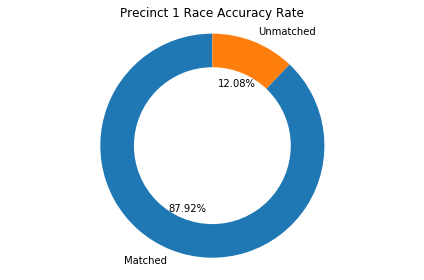

In [26]:
# This code makes donut pie chart

precinct_1_notMatch = (100 - preccint_one_percent)
chart = [preccint_one_percent, precinct_1_notMatch]
labels = ['Matched','Unmatched']
#colors = ['TBD']

fig1, ax1 = plt.subplots()
ax1.pie(chart, labels=labels, autopct='%1.2f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
# adding title
plt.title("Precinct 1 Race Accuracy Rate")
# save the figure
plt.savefig("pre1_race_accuracy.png")
plt.tight_layout()
plt.show()


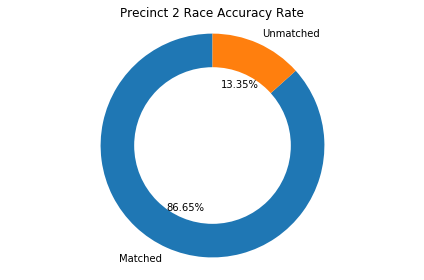

In [27]:
# This code makes donut pie chart

precinct_2_notMatch = (100 - preccint_two_percent)
chart = [preccint_two_percent, precinct_2_notMatch]
labels = ['Matched','Unmatched']
#colors = ['TBD']

fig1, ax1 = plt.subplots()
ax1.pie(chart, labels=labels, autopct='%1.2f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
# adding title
plt.title("Precinct 2 Race Accuracy Rate")
# save the figure
plt.savefig("pre2_race_accuracy.png")
plt.tight_layout()
plt.show()



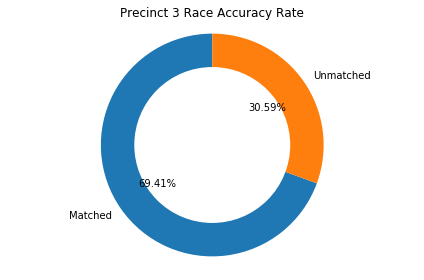

In [28]:
# This code makes donut pie chart

precinct_3_notMatch = (100 - preccint_three_percent)
chart = [preccint_three_percent, precinct_3_notMatch]
labels = ['Matched','Unmatched']
#colors = ['TBD']

fig1, ax1 = plt.subplots()
ax1.pie(chart, labels=labels, autopct='%1.2f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
# adding title
plt.title("Precinct 3 Race Accuracy Rate")
# save the figure
plt.savefig("pre3_race_accuracy.png")
plt.tight_layout()
plt.show()



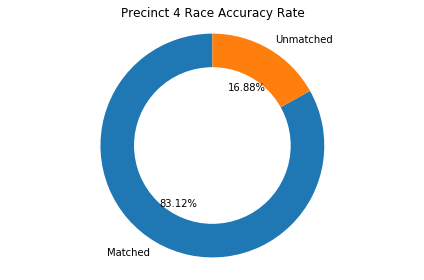

In [29]:
# This code makes donut pie chart

precinct_4_notMatch = (100 - preccint_four_percent)
chart = [preccint_four_percent, precinct_4_notMatch]
labels = ['Matched','Unmatched']
#colors = ['TBD']

fig1, ax1 = plt.subplots()
ax1.pie(chart, labels=labels, autopct='%1.2f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
# adding title
plt.title("Precinct 4 Race Accuracy Rate")
# save the figure
plt.savefig("pre4_race_accuracy.png")
plt.tight_layout()
plt.show()



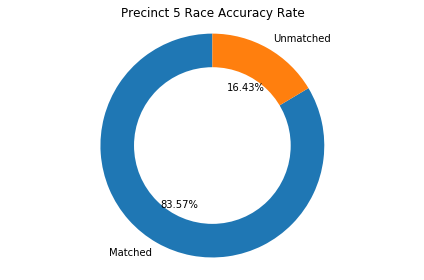

In [30]:
# This code makes donut pie chart

precinct_5_notMatch = (100 - preccint_five_percent)
chart = [preccint_five_percent, precinct_5_notMatch]
labels = ['Matched','Unmatched']
#colors = ['TBD']

fig1, ax1 = plt.subplots()
ax1.pie(chart, labels=labels, autopct='%1.2f%%', startangle=90)
#draw circle
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)
# Equal aspect ratio ensures that pie is drawn as a circle
ax1.axis('equal')  
# adding title
plt.title("Precinct 5 Race Accuracy Rate")
# save the figure
plt.savefig("pre5_race_accuracy.png")
plt.tight_layout()
plt.show()



In [31]:
### some group discussion on additional work to do
# independent ttest or other statistical analysis
# dexplot that compares gender to race (likelihood of stops by gender and likelihood of stops by race by precinct)
# could do something with prerace and race match - xyz precinct is more likely to have a match than abc precinct

(<Figure size 720x576 with 2 Axes>,)

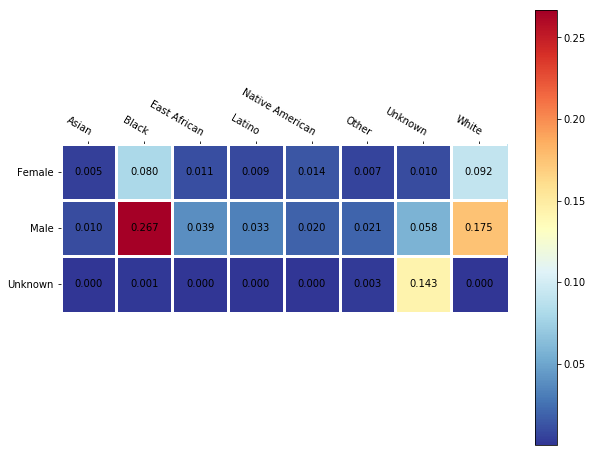

In [41]:
# creating a heat map based on gender and race for entire data set
testDF = cleanDF
# del testDF['Unnamed: 0']
# del testDF['idNum']
# del testDF['date']
# del testDF['MDC']
# del testDF['citationIssued']
# del testDF['personSearch']
# del testDF['vehicleSearch']
# del testDF['preRace']
# del testDF['lat']
# del testDF['long']
# del testDF['policePrecinct']
# del testDF['neighborhood']
# del testDF['Time']
# del testDF['problem']
testDF['Count'] = 1

#del testDF#, 'date', 'MDC', 'citationIssued', 'personSearch', 'vehicleSearch', 'preRace', 'lat', 'long', 'policePrecinct', 'neighborhood', 'Time']
testDF.head()

dxp.heatmap(x='race', y='gender', agg='Count', aggfunc='sum', data=testDF, annot=True, fmt='.3f', normalize='all')
